# Proiect PCLP3
## Creare baza de date si antrenare model ML pentru aproximarea valorii crypto-monedelor
Proiectul rezolva o problema de regresie - aproximarea valorii actuale a monedelor de pe piata crypto. Pentru aproximarea `curent_price` se analizeaza:
- `market_cap`: capitalizarea totala de piata a monedei
- `total_volume`: volumul total tranzactionat in ultimele 24 de ore
- `high_24h` si `low_24h`: pretul maxim si minim din ultimele 24 de ore
- `price_change_percentage_24h`: variatia procentuala a pretului intr-o zi
- `circulating_supply`: numarul de monede aflate in circulatie
- `total_supply`: numarul total de monede disponibile
- `ath`: cel mai mare pret atins vreodata
- `atl`: cel mai mic pret atins vreodata

Datele despre monede se iau din baza de date a celor de la [CoinGecko](https://www.coingecko.com/) prin intermediul API-ului [CoinGeckoAPI](https://www.coingecko.com/en/api).


In [156]:
import requests
import pandas

key = "CG-pcNuwgew6eE9cBsPmm4d1uLA"

all_data = []

# se fac 3 call-uri pentru paginile 1, 2 și 3 pentru a stange 750 de monede/linii
for page in range(1, 4):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd", # moneda in care sunt exprimate valorile
        "per_page": 250, # numar de monede citite (maxim per pagina)
        "page": page, # pagina de la care se citeste
    }
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": key
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        all_data.extend(data)
    else:
        print(f"Eroare la pagina {page}: {response.status_code}")

# numarul de linii primite
print(f"Numar total de monede colectate: {len(all_data)}")

# convertesc in DataFrame
df = pandas.DataFrame(all_data)

# enumerare coloane
print(df.columns)


Numar total de monede colectate: 750
Index(['id', 'symbol', 'name', 'image', 'current_price', 'market_cap',
       'market_cap_rank', 'fully_diluted_valuation', 'total_volume',
       'high_24h', 'low_24h', 'price_change_24h',
       'price_change_percentage_24h', 'market_cap_change_24h',
       'market_cap_change_percentage_24h', 'circulating_supply',
       'total_supply', 'max_supply', 'ath', 'ath_change_percentage',
       'ath_date', 'atl', 'atl_change_percentage', 'atl_date', 'roi',
       'last_updated'],
      dtype='object')


Acestea sunt coloanele (parametrii) primiti prin API.

## Prelucrari date
Liniile cu valori NaN sunt eliminate, numarul lor fiind unul mic si valorile de pe coloane avand diferente foarte mari intre ele.
Se afiseaza cu `describe()` diferite statistici despre datele primite prin API.
In features se afla toate coloanele non-tinta.

In [157]:
features = [
    "name",
    "market_cap",
    "total_volume",
    "high_24h", # cea mai mare valoare din ultimele 24h
    "low_24h",  # cea mai mica valoare din ultimele 24h
    "price_change_percentage_24h",
    "circulating_supply",
    "total_supply",
    "ath", # all time high
    "atl"  # all time low
]

df = df[features + ["current_price"]].dropna()
print(f"Numar de linii ramase dupa eliminare: {df.shape[0]}")
print(df.describe())


Numar de linii ramase dupa eliminare: 745
         market_cap  total_volume      high_24h       low_24h  \
count  7.450000e+02  7.450000e+02  7.450000e+02  7.450000e+02   
mean   4.746234e+09  1.758550e+08  3.579629e+03  3.483364e+03   
std    7.952745e+10  1.961153e+09  1.888312e+04  1.840510e+04   
min    4.692325e+07  0.000000e+00  1.694000e-09  1.603000e-09   
25%    7.803146e+07  8.254730e+05  8.419600e-02  7.523400e-02   
50%    1.408681e+08  6.962101e+06  5.188160e-01  4.849850e-01   
75%    4.253280e+08  2.287598e+07  2.980000e+00  2.750000e+00   
max    2.135890e+12  4.256637e+10  1.144680e+05  1.115870e+05   

       price_change_percentage_24h  circulating_supply  total_supply  \
count                   745.000000        7.450000e+02  7.450000e+02   
mean                     -2.798891        2.354836e+14  5.761460e+14   
std                       4.659642        6.110033e+15  1.538757e+16   
min                     -61.333840        4.403968e+02  4.403968e+02   
25%         

## Histograme pentru valorile numerice

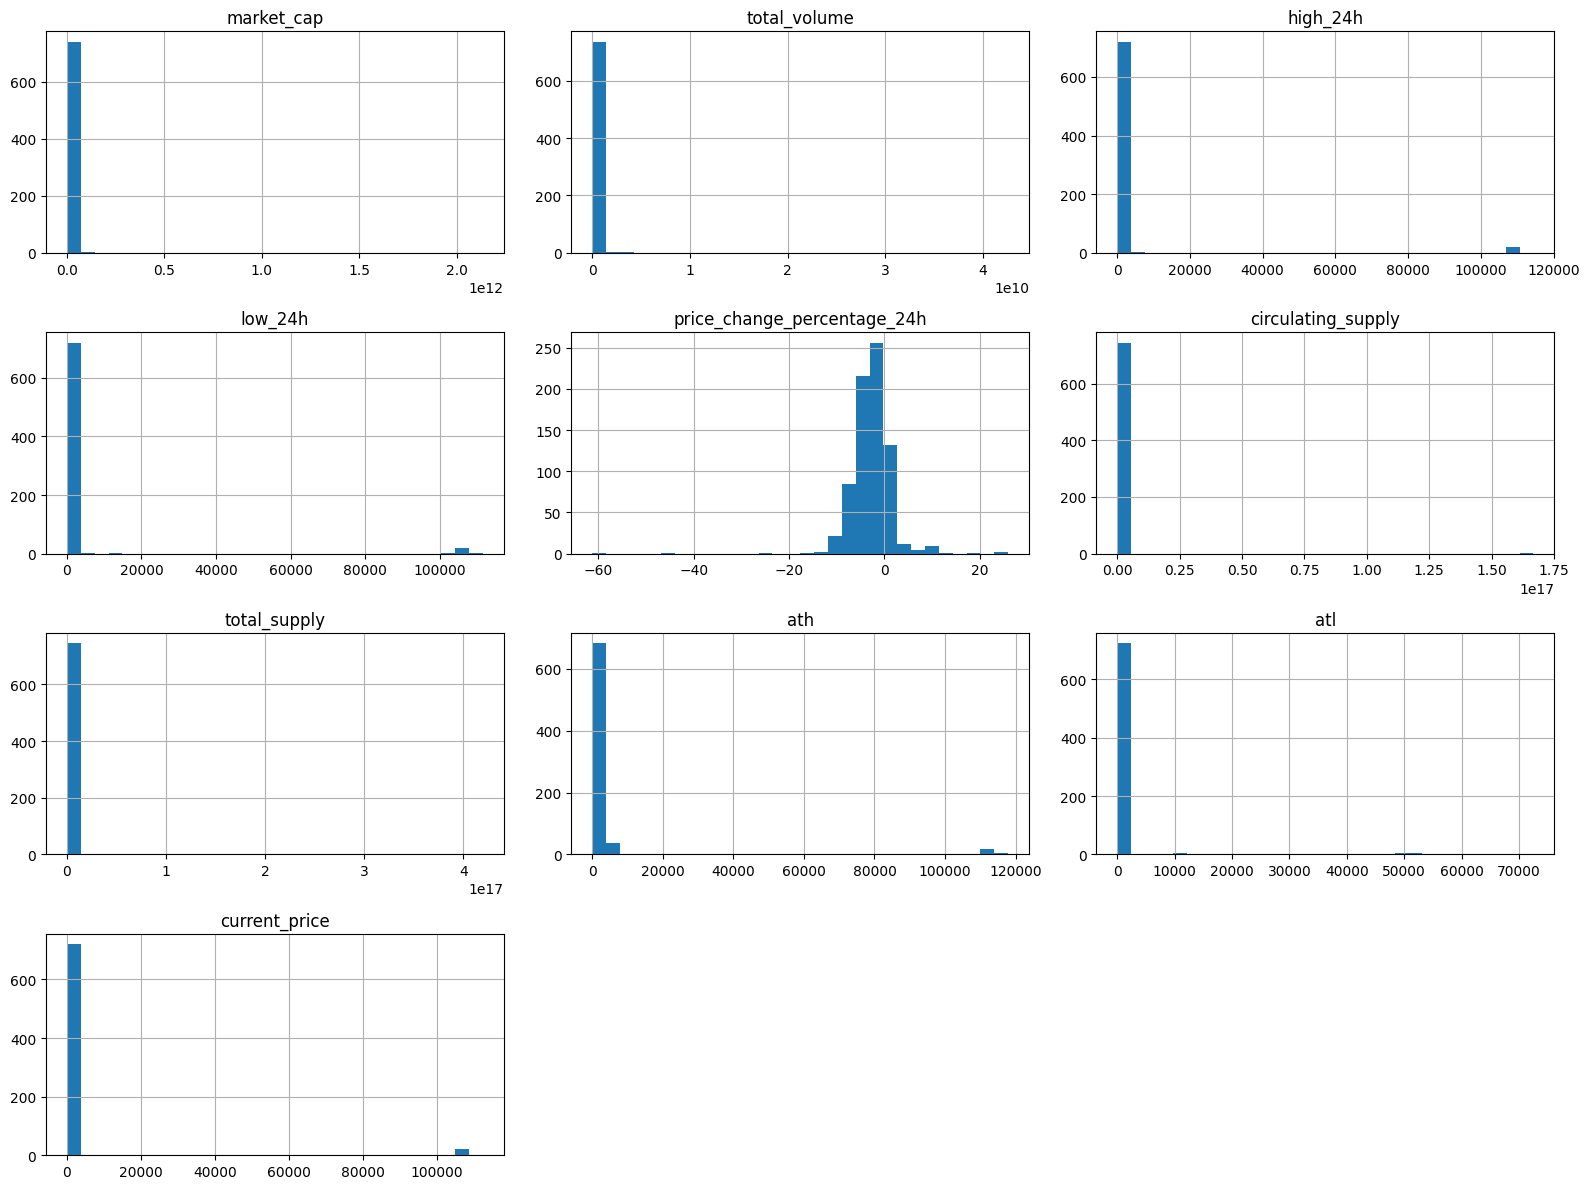

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[numeric_cols].hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()

Se poate observa faptul sunt doua categorii de monede in datele primite: monede cu valori mici si monede cu valori extrem de mari, cele mici reprezentand majoritatea absoluta.

## Impartirea datelor in train si test

In [159]:
from sklearn.model_selection import train_test_split

# amestec liniile aleatoriu
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# setez X și y
x = df[features]
y = df["current_price"]

# split intre datele de antrenament si cele de test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

## Scriu csv-urile cu train si test

In [160]:
train_data = X_train.copy()
train_data["current_price"] = y_train
train_data.to_csv("train_data.csv", index=False)

test_data = X_test.copy()
test_data["current_price"] = y_test
test_data.to_csv("test_data.csv", index=False)

print(f"Numar de linii în train_data: {train_data.shape[0]}")
print(f"Numar de linii în test_data: {test_data.shape[0]}")

Numar de linii în train_data: 521
Numar de linii în test_data: 224


## Antrenarea modelului de regresie liniara
Modelul aproximeaza valoarea curenta a unei monede, luand in considerare parametrii cunoscuti.

In [161]:
import numpy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train = X_train.drop(columns=['name'])
X_test = X_test.drop(columns=['name'])

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.9873328256661125
MAE: 251.89971189803632
RMSE: 1953.5906976453045


In urma rezultatelor metodelor de verificare a preciziei modelului se observa faptul ca modelul are precizie buna, dar cand da valori gresite are eroare foarte mare.

## Grafic - Distributia erorilor

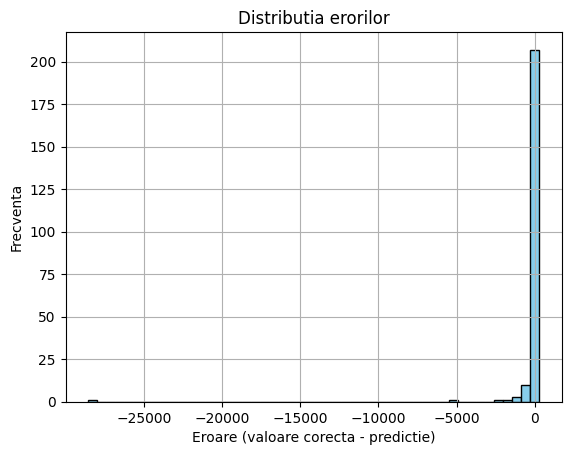

In [162]:
errors = y_test - y_pred
plt.hist(errors, bins=50, color="skyblue", edgecolor="black")
plt.title("Distributia erorilor")
plt.xlabel("Eroare (valoare corecta - predictie)")
plt.ylabel("Frecventa")
plt.grid(True)
plt.show()